<a href="https://colab.research.google.com/github/robinanwyl/oud_transcriptomics/blob/main/BENG204_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BENG 204 Project: Understanding Transcriptional Responses to Opioid Exposure Across Neurodevelopmental Stages in Brain Organoid Models

## Notebook Setup

Run this cell every time the notebook is opened to mount the drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If any import statements cannot be resolved, run this cell to re-install those packages.

In [ ]:
%pip install scanpy
%pip install anndata
%pip install pydeseq2
#%pip install gseapy

Import statements

In [3]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import random
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
# etc.

## Read in Kim et al scRNA-seq 10X output files and save as .h5ad.gz files (perform once)

**Read in the scRNA-seq data for Kim et al dataset day 53 untreated sample and day 53 acute fentanyl treatment sample, add metadata and prepend cell barcodes with unique identifiers, and save each sample as a separate `.h5ad.gz` file. Then merge the datasets and save the merged dataset as a `h5ad.gz` file as well.**

The original sample IDs are KH001 for the day 53 untreated sample and KH002 for the day 53 acute fentanyl treatment sample. Each sample has its own folder containing 3 compressed (`.gz`) files, which are the 10X Genomics CellRanger output files:

*   `matrix.mtx.gz` is a count matrix where rows are single cells, columns are genes, and each cell is the read count of that gene in that cell
*   `barcodes.tsv.gz` contains the cell barcodes (each cell is labeled with a unique barcode, which is used as an identifier)
*   `features.tsv.gz` contains the gene names

For each of the 2 samples, we will first use `scanpy.read_10x_mtx()` to read the 3 files into a single `AnnData` object that contains the cell-by-gene matrix and associated metadata (`obs` = barcodes, `var` = features). We will add columns to the `obs` attribute, `Sample` indicating the sample name and `condition` indicating the treatment group of the sample (untreated or fentanyl). In preparation for merging these samples into one `AnnData` object later, we will prepend the cell barcodes with a sample description, "d53_ut" for untreated samples and "d53_fty" for treated samples. Then we will save each sample `AnnData` object as a compressed `.h5ad.gz` file for later use.

In [ ]:
# sample1_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH001_Day53_Untreated"
# adata1 = sc.read_10x_mtx(sample1_path, var_names="gene_symbols", cache=True)
# adata1.obs["Sample"] = "kim_day53_untreated"
# adata1.obs["condition"] = "untreated"
# adata1.obs.index = [f"d53_ut_{barcode}" for barcode in adata1.obs.index]
# adata1.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ut.h5ad.gz", compression="gzip")

# sample2_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH002_Day53_FTY_Acute"
# adata2 = sc.read_10x_mtx(sample2_path, var_names="gene_symbols", cache=True)
# adata2.obs["Sample"] = "kim_d53_fty_acute"
# adata2.obs["condition"] = "untreated"
# adata2.obs.index = [f"d53_fty_{barcode}" for barcode in adata2.obs.index]
# adata2.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_fty.h5ad.gz", compression="gzip")

Now we will merge the two samples into one `AnnData` object and save the merged dataset as a `.h5ad.gz` file as well.

In [ ]:
# adata_combined = sc.concat([adata1, adata2], label="orig_sample", keys=["sample1", "sample2"])
# adata_combined.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz", compression="gzip")

## QC and preprocessing on Kim et al scRNA-seq dataset

We will read in the Kim et al combined dataset as an `AnnData` object using `scanpy.read_h5ad()`.

In [ ]:
# kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz")

Before QC and preprocessing, we will create a `counts` layer in the `AnnData` object to store the raw counts.

In [ ]:
# kim_d53.layers["counts"] = kim_d53.X.copy()

We will follow the `scanpy` tutorial for QC and preprocessing. We will first calculate common QC metrics.


In [ ]:
# kim_d53.var["mt"] = kim_d53.var_names.str.startswith("MT-") # mitochondrial genes
# sc.pp.calculate_qc_metrics(kim_d53, qc_vars=["mt"], inplace=True, log1p=False)

We will now inspect violin plots for number of genes expressed, total counts per cell, and percentage of counts in mitochondrial genes.

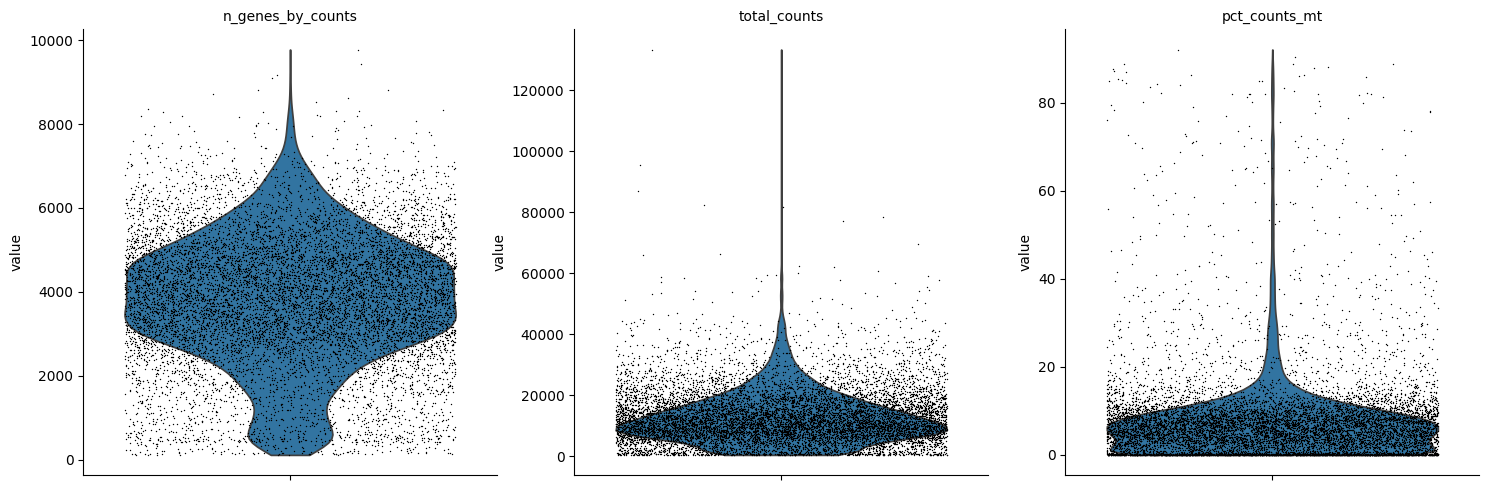

In [ ]:
# sc.pl.violin(
#     kim_d53,
#     ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
#     jitter=0.4,
#     multi_panel=True,
# )

We can also inspect a joint scatterplot of all 3 metrics.

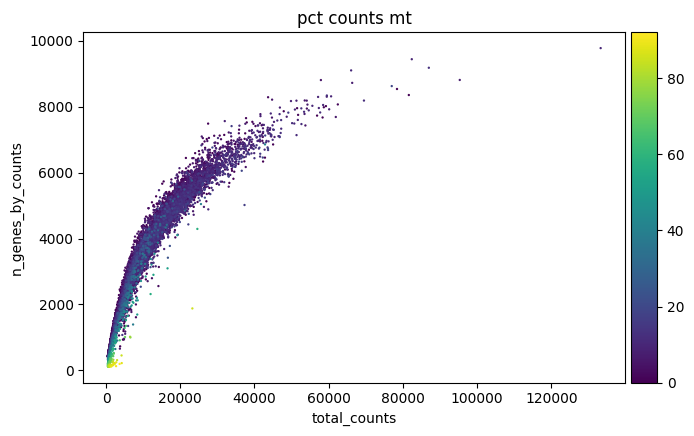

In [ ]:
# sc.pl.scatter(kim_d53, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

We will filter out cells with fewer than 100 genes expressed and genes expressed in fewer than 3 cells; these thresholds are used in the `scanpy` tutorial and are reasonable for this dataset based on the violin plots. Additionally, we will filter out cells with >20% mitochondrial genes, consistent with brain organoid transcriptomic studies [Vertesy et al (2022)](https://www.embopress.org/doi/full/10.15252/embj.2022111118) and [Fleck et al (2023)](https://www.nature.com/articles/s41586-022-05279-8).

In [ ]:
# print(f"Number of cells before filtering: {kim_d53.n_obs}")
# print(f"Number of genes before filtering: {kim_d53.n_vars}")

Number of cells before filtering: 10630
Number of genes before filtering: 33538


In [ ]:
# sc.pp.filter_cells(kim_d53, min_genes=100)
# sc.pp.filter_genes(kim_d53, min_cells=3)
# kim_d53 = kim_d53[kim_d53.obs["pct_counts_mt"] <= 20]
# print(f"Number of cells after filtering: {kim_d53.n_obs}")
# print(f"Number of genes after filtering: {kim_d53.n_vars}")

Number of cells after filtering: 10029
Number of genes after filtering: 24368


We will save the `AnnData` object with the cell barcodes and genes that passed QC as a `.h5ad.gz` file.

In [ ]:
# kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz", compression="gzip")

## Pseudobulk representation and differential expression analysis on Kim et al scRNA-seq dataset

Read in the QC-passed `AnnData` object:

In [48]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz")

The following function creates a pseudobulk representation of a multi-sample `AnnData` object. Each sample is randomly split into a given number of pseudoreplicates.

In [49]:
def pseudobulk_with_pseudoreps(adata, n):
  """
  Generate the pseudobulk representation of adata with n pseudoreplicates per
  sample, using randomly chosen cells for each pseudoreplicate.
  """
  all_pseudoreps = list()
  for sample in adata.obs.Sample.unique():
    # Get sample cell subset
    samp_cell_subset = adata[adata.obs.Sample == sample]
    # Use raw data
    if "counts" in samp_cell_subset.layers:
      samp_cell_subset.X = samp_cell_subset.layers["counts"]
    # Split indices into n random pseudoreplicates
    indices = list(samp_cell_subset.obs_names)
    random.shuffle(indices)
    indices = np.array_split(np.array(indices), n)
    # Create a single-row AnnData object for each pseudoreplicate
    for i, pseudo_rep in enumerate(indices):
      X = samp_cell_subset[indices[i]].X.sum(axis = 0)
      rep_adata = sc.AnnData(X = np.asarray(samp_cell_subset[indices[i]].X.sum(axis = 0)),
                            var = samp_cell_subset[indices[i]].var[[]])
      rep_adata.obs_names = [sample + '_' + str(i)]
      rep_adata.obs['condition'] = samp_cell_subset.obs['condition'].iloc[0]
      rep_adata.obs['replicate'] = i
      all_pseudoreps.append(rep_adata)
  # Combine all pseudoreplicates into one AnnData object
  pseudobulk = sc.concat(all_pseudoreps)
  return pseudobulk

We will filter out genes expressed in fewer than 10 cells, as performed in the PyDESeq2 tutorial. Then we will generate a pseudobulk dataset with 3 pseudoreplicates.

In [64]:
sc.pp.filter_genes(kim_d53, min_cells=10)
random.seed(42)
pb3 = pseudobulk_with_pseudoreps(kim_d53, 3)

Next, we will perform differential expression analysis using `PyDESeq2`. First, we will create a `DeseqDataSet` object from the pseudobulk dataset. We will filter out genes that are expressed in fewer than 10 cells. Then we will fit dispersions and log-fold-changes (LFCs) for differential expression analysis.

In [73]:
dds3 = DeseqDataSet(adata=pb3, design="~condition")
dds3.deseq2()

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 20.98 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 28.40 seconds.

Fitting LFCs...
... done in 13.99 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Now we will perform statistical testing, including LFC shrinkage to shrink LFCs of genes with low information.

In [77]:
dstats3 = DeseqStats(dds3, contrast=["condition", "fentanyl", "untreated"])
dstats3.summary()
dstats3.lfc_shrink(coeff="condition[T.untreated]")

Running Wald tests...
... done in 6.65 seconds.



Log2 fold change & Wald test p-value: condition fentanyl vs untreated
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.1   11.137541        0.349185  0.543798  0.642123  0.520793       NaN
AL669831.5  442.908281       -0.255855  0.088513 -2.890604  0.003845  0.025015
FAM87B        2.325514       -0.379598  1.163642 -0.326216  0.744261       NaN
LINC00115    76.862222       -0.275769  0.203822 -1.352990  0.176059  0.381803
FAM41C       53.831229        0.431648  0.247260  1.745724  0.080859  0.229078
...                ...             ...       ...       ...       ...       ...
AC136352.3    2.494533       -0.160619  1.182681 -0.135809  0.891972       NaN
AC011043.1  223.887463       -0.175454  0.121118 -1.448622  0.147443  0.342848
AC007325.4  217.253012       -0.084922  0.118288 -0.717929  0.472801  0.687258
AC004556.1  503.939763        0.295370  0.080018  3.691306  0.000223  0.002660
AC240274.1  191.769307        0.173490  0.132114  1.313182  0

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.untreated]
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.1   11.137541       -0.011219  0.132806  0.642123  0.520793       NaN
AL669831.5  442.908281        0.203647  0.090505 -2.890604  0.003845  0.025015
FAM87B        2.325514        0.002740  0.144590 -0.326216  0.744261       NaN
LINC00115    76.862222        0.060329  0.138680 -1.352990  0.176059  0.381803
FAM41C       53.831229       -0.072981  0.155983  1.745724  0.080859  0.229078
...                ...             ...       ...       ...       ...       ...
AC136352.3    2.494533        0.001128  0.141552 -0.135809  0.891972       NaN
AC011043.1  223.887463        0.083244  0.108125 -1.448622  0.147443  0.342848
AC007325.4  217.253012        0.036223  0.094282 -0.717929  0.472801  0.687258
AC004556.1  503.939763       -0.256854  0.081747  3.691306  0.000223  0.002660
AC240274.1  191.769307       -0.071839  0.110809  1.313182  0.1

... done in 41.82 seconds.



In [70]:
ds3_df = dstats3.results_df
ds3_df.sort_values('log2FoldChange', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TNK2-AS1,30.412034,4.081701,1.079248,-4.363643,1.279145e-05,NaN
IFI30,22.442815,2.279778,0.505771,-4.960412,7.034397e-07,NaN
HIST1H2BE,143.935560,2.166203,0.655401,-4.026592,5.659100e-05,8.571233e-04
APOBEC3A,13.507429,2.041782,0.584797,-4.056356,4.984424e-05,NaN
AGTR1,109.523431,1.983394,0.355912,-5.998184,1.995368e-09,1.219908e-07
...,...,...,...,...,...,...
CYP1B1,11.768368,-3.407860,0.765483,4.824127,1.406181e-06,NaN
EN1,85.067710,-3.530285,0.308933,11.604301,3.918771e-31,7.495490e-28
HOXA10,7.560221,-4.651072,1.373759,3.568049,3.596489e-04,NaN
MGP,126.110576,-5.341776,0.587057,9.343547,9.315974e-21,3.779745e-18


In [71]:
ds3_df.sort_values('stat', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ACTB,68720.812095,-0.298192,0.019856,15.148877,7.707283e-52,1.031928e-47
BDNF,1596.948836,-0.805505,0.054531,14.936464,1.908352e-50,1.277546e-46
SRSF6,1771.746494,-0.654795,0.046013,14.396964,5.406707e-47,1.809760e-43
MTRNR2L8,44181.821893,-0.274631,0.021214,13.083718,4.079882e-39,1.092511e-35
SRSF3,9808.801116,-0.331877,0.026029,12.907165,4.101235e-38,9.151906e-35
...,...,...,...,...,...,...
NKX2-1,970.669363,0.703040,0.065881,-10.886165,1.341718e-27,1.283161e-24
TCEAL9,3373.721894,0.381555,0.035041,-11.078627,1.592960e-28,1.938922e-25
AP2B1,4868.958649,0.340312,0.030985,-11.164735,6.067197e-29,8.123370e-26
NRN1,4386.986821,0.382219,0.034485,-11.269661,1.852822e-29,3.100930e-26


In [78]:
ds3_df.sort_values('log2FoldChange', ascending = False, inplace=True)
degs3_df = ds3_df[ds3_df["padj"] <= 0.05]
degs3_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
HIST1H2BE,143.935560,2.166203,0.655401,-4.026592,5.659100e-05,8.571233e-04
AGTR1,109.523431,1.983394,0.355912,-5.998184,1.995368e-09,1.219908e-07
DLX1,51.675716,1.355645,0.260112,-5.632978,1.771236e-08,8.469669e-07
PAX6,601.686242,1.347202,0.266164,-5.535328,3.106468e-08,1.395721e-06
GAD2,284.641507,1.332222,0.309827,-4.852940,1.216446e-06,3.162523e-05
...,...,...,...,...,...,...
ITM2A,94.294318,-1.322233,0.429781,3.865558,1.108353e-04,1.494435e-03
POSTN,167.153124,-1.351747,0.165187,8.485180,2.153859e-17,5.243276e-15
LUM,58.628674,-2.928405,0.311064,9.639087,5.467185e-22,2.711116e-19
EN1,85.067710,-3.530285,0.308933,11.604301,3.918771e-31,7.495490e-28


## Analysis on Ho et al bulk RNA-seq data

First, we read in Ho et al bulk RNA-seq data, which is in the form of a gene-by-sample matrix within a .txt file. We then transpose this matrix into a sample-by-gene matrix, from which we then remove genes that are not expressed in at least 10 cells.

In [ ]:
counts_raw = pd.read_table("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GSE210206_counts.txt", index_col=0, header=0)
#Transposing data:
counts_df = counts_raw.T
print(f"Number of genes before filtering: {counts_df.shape[1]}")
#Filtering data:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]
print(f"Number of genes after filtering: {counts_df.shape[1]}")
counts_df.head()

Number of genes before filtering: 25370
Number of genes after filtering: 20694


gene_symbol,WASH7P,LOC729737,LOC100133331,MIR6723,LOC100288069,FAM87B,LINC00115,LINC01128,FAM41C,LOC100130417,...,NLGN4Y-AS1,NCRNA00185,TTTY14,CD24,BCORP1,TXLNGY,KDM5D,TTTY10,EIF1AY,RPS4Y2
OFO1003B1,448,137,65,67,40,9,40,503,2,71,...,4,22,23,5745,4,327,702,3,344,2
OFO1003B2,437,121,82,101,42,8,17,512,3,65,...,4,25,23,5750,2,304,745,1,363,0
OFO1003O1,412,116,74,51,34,3,50,206,0,38,...,4,15,8,3522,1,226,470,3,476,0
OFO1003O2,510,110,73,64,28,5,32,242,1,50,...,2,18,13,3924,1,233,569,2,560,1
OFO1003V1,637,184,67,46,47,6,108,427,0,62,...,5,17,25,5973,3,356,761,2,526,0


Now, we read in our sample metadata:

In [ ]:
metadata_Ho = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_metadata.csv", index_col=0)
metadata_Ho.head()

,Condition
Sample,
OFO1003B1,buprenorphine
OFO1003B2,buprenorphine
OFO1003O1,oxycodone
OFO1003O2,oxycodone
OFO1003V1,PBS


Now, we create our `DeseqDataSet` object and then fit said object with dispersions and LFCs for differential expression analysis.

In [ ]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_Ho,
    design="~Condition"
)
dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 36.57 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 45.93 seconds.

Fitting LFCs...
... done in 18.00 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.



We will now perform our statistical analyses upon the aforementioned DeseqDataSet by first creating a `DeseqStats` object & then running the `summary()` method.

In [ ]:
ds = DeseqStats(dds, contrast=["Condition", "oxycodone", "PBS"])
ds.summary()

Running Wald tests...
... done in 7.08 seconds.



Log2 fold change & Wald test p-value: Condition oxycodone vs PBS
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                              
WASH7P        344.202941       -0.021586  0.327446 -0.065923  0.947439   
LOC729737     102.130186       -0.250510  0.316119 -0.792454  0.428096   
LOC100133331   66.223814        0.089953  0.174544  0.515359  0.606302   
MIR6723        65.966132        0.007637  0.233102  0.032763  0.973864   
LOC100288069   41.854978        0.044645  0.191099  0.233622  0.815279   
...                  ...             ...       ...       ...       ...   
TXLNGY        378.969377       -0.020204  0.186730 -0.108199  0.913838   
KDM5D         694.759371       -0.054766  0.081218 -0.674307  0.500116   
TTTY10          3.112367       -0.767770  0.648624 -1.183692  0.236535   
EIF1AY        607.783994        0.298369  0.239899  1.243727  0.213600   
RPS4Y2          0.929605        1.184722  1.365

Here, we perform LFC shrinkage to improve the accuracy of our estimates via shrinking LFC estimates of genes with low information (e.g. low counts or high dispersions) towards 0.

In [ ]:
ds.lfc_shrink(coeff="Condition[T.oxycodone]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: Condition[T.oxycodone]
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                              
WASH7P        344.202941       -0.000782  0.063557 -0.065923  0.947439   
LOC729737     102.130186       -0.010161  0.064603 -0.792454  0.428096   
LOC100133331   66.223814        0.010999  0.061906  0.515359  0.606302   
MIR6723        65.966132        0.000569  0.062428  0.032763  0.973864   
LOC100288069   41.854978        0.004627  0.061568  0.233622  0.815279   
...                  ...             ...       ...       ...       ...   
TXLNGY        378.969377       -0.002112  0.061246 -0.108199  0.913838   
KDM5D         694.759371       -0.022112  0.053306 -0.674307  0.500116   
TTTY10          3.112367       -0.007808  0.065157 -1.183692  0.236535   
EIF1AY        607.783994        0.021386  0.067444  1.243727  0.213600   
RPS4Y2          0.929605        0.002804  0.

... done in 48.83 seconds.



Here, we view the results of the above Wald tests.

In [ ]:
ds_df = ds.results_df
ds_df.sort_values('log2FoldChange', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
SLC22A8,17.545470,2.905353,0.904686,4.085724,0.000044,0.057740
TMEM72,28.752807,2.665592,0.712462,4.490036,0.000007,0.015206
ATP13A5,58.578079,2.493514,0.896273,3.788270,0.000152,0.097874
AQP1,1627.090430,2.001534,0.716442,3.786702,0.000153,0.097874
CPA4,51.445319,1.997733,0.820159,3.550174,0.000385,0.118537
...,...,...,...,...,...,...
DACH2,48.335752,-1.207924,0.331860,-4.401986,0.000011,0.020360
CYP4X1,45.521659,-1.252895,0.425906,-3.867435,0.000110,0.097874
LINC01106,7.020388,-1.475731,0.549401,-3.599393,0.000319,0.114981


We want to view genes that demonstrate the highest or lowest log2fold changes, but with padj <= 0.05.

---



In [ ]:
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
DEGs_df = ds_df[ds_df["padj"] <= 0.05]
DEGs_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
TMEM72,28.752807,2.665592,0.712462,4.490036,7.121108e-06,0.015206
PTGER2,33.517680,1.533124,0.444303,4.254655,2.093713e-05,0.035767
AGPAT9,114.833434,1.239933,0.329331,4.509245,6.505866e-06,0.015206
TIMP3,1521.537448,0.874927,0.223534,4.630080,3.655247e-06,0.013992
MOSPD1,400.777753,0.627025,0.162526,4.568405,4.914501e-06,0.013992
ICT1,336.556565,0.415894,0.099100,4.833475,1.341704e-06,0.007640
VKORC1,1213.250268,0.256509,0.045891,6.020707,1.736570e-09,0.000030
SRI,1236.440551,0.211202,0.059443,4.161965,3.155211e-05,0.049000
MMP3,83.840282,-0.023353,0.071248,-5.239670,1.608637e-07,0.001374


Now, we export both our results & the differentially expressed genes as .csv files.

In [ ]:
# ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")
# DEGs_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_DEGs.csv")

## Visualizing Ho et al DEGs

Read in results of statistical analysis

In [6]:
ds_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")
DEGs_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_DEGs.csv")
ds_df.head()

,gene_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,SLC22A8,17.545470,2.905353,0.904686,4.085724,0.000044,0.057740
1,TMEM72,28.752807,2.665592,0.712462,4.490036,0.000007,0.015206
2,ATP13A5,58.578079,2.493514,0.896273,3.788270,0.000152,0.097874
3,AQP1,1627.090430,2.001534,0.716442,3.786702,0.000153,0.097874
4,CPA4,51.445319,1.997733,0.820159,3.550174,0.000385,0.118537


We will add a column to the results `DataFrame` indicating whether a gene is non-significant (ns), significant and increases in expression (up), or significant and decreases in expression (down).

In [27]:
ds_df["significance"] = np.where(ds_df["padj"] > 0.05, "ns", np.where(ds_df["log2FoldChange"] > 0, "up", "down"))

We will save the results DataFrame:


In [39]:
#ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")

We now plot the log2 fold-change versus mean expression between both conditions.

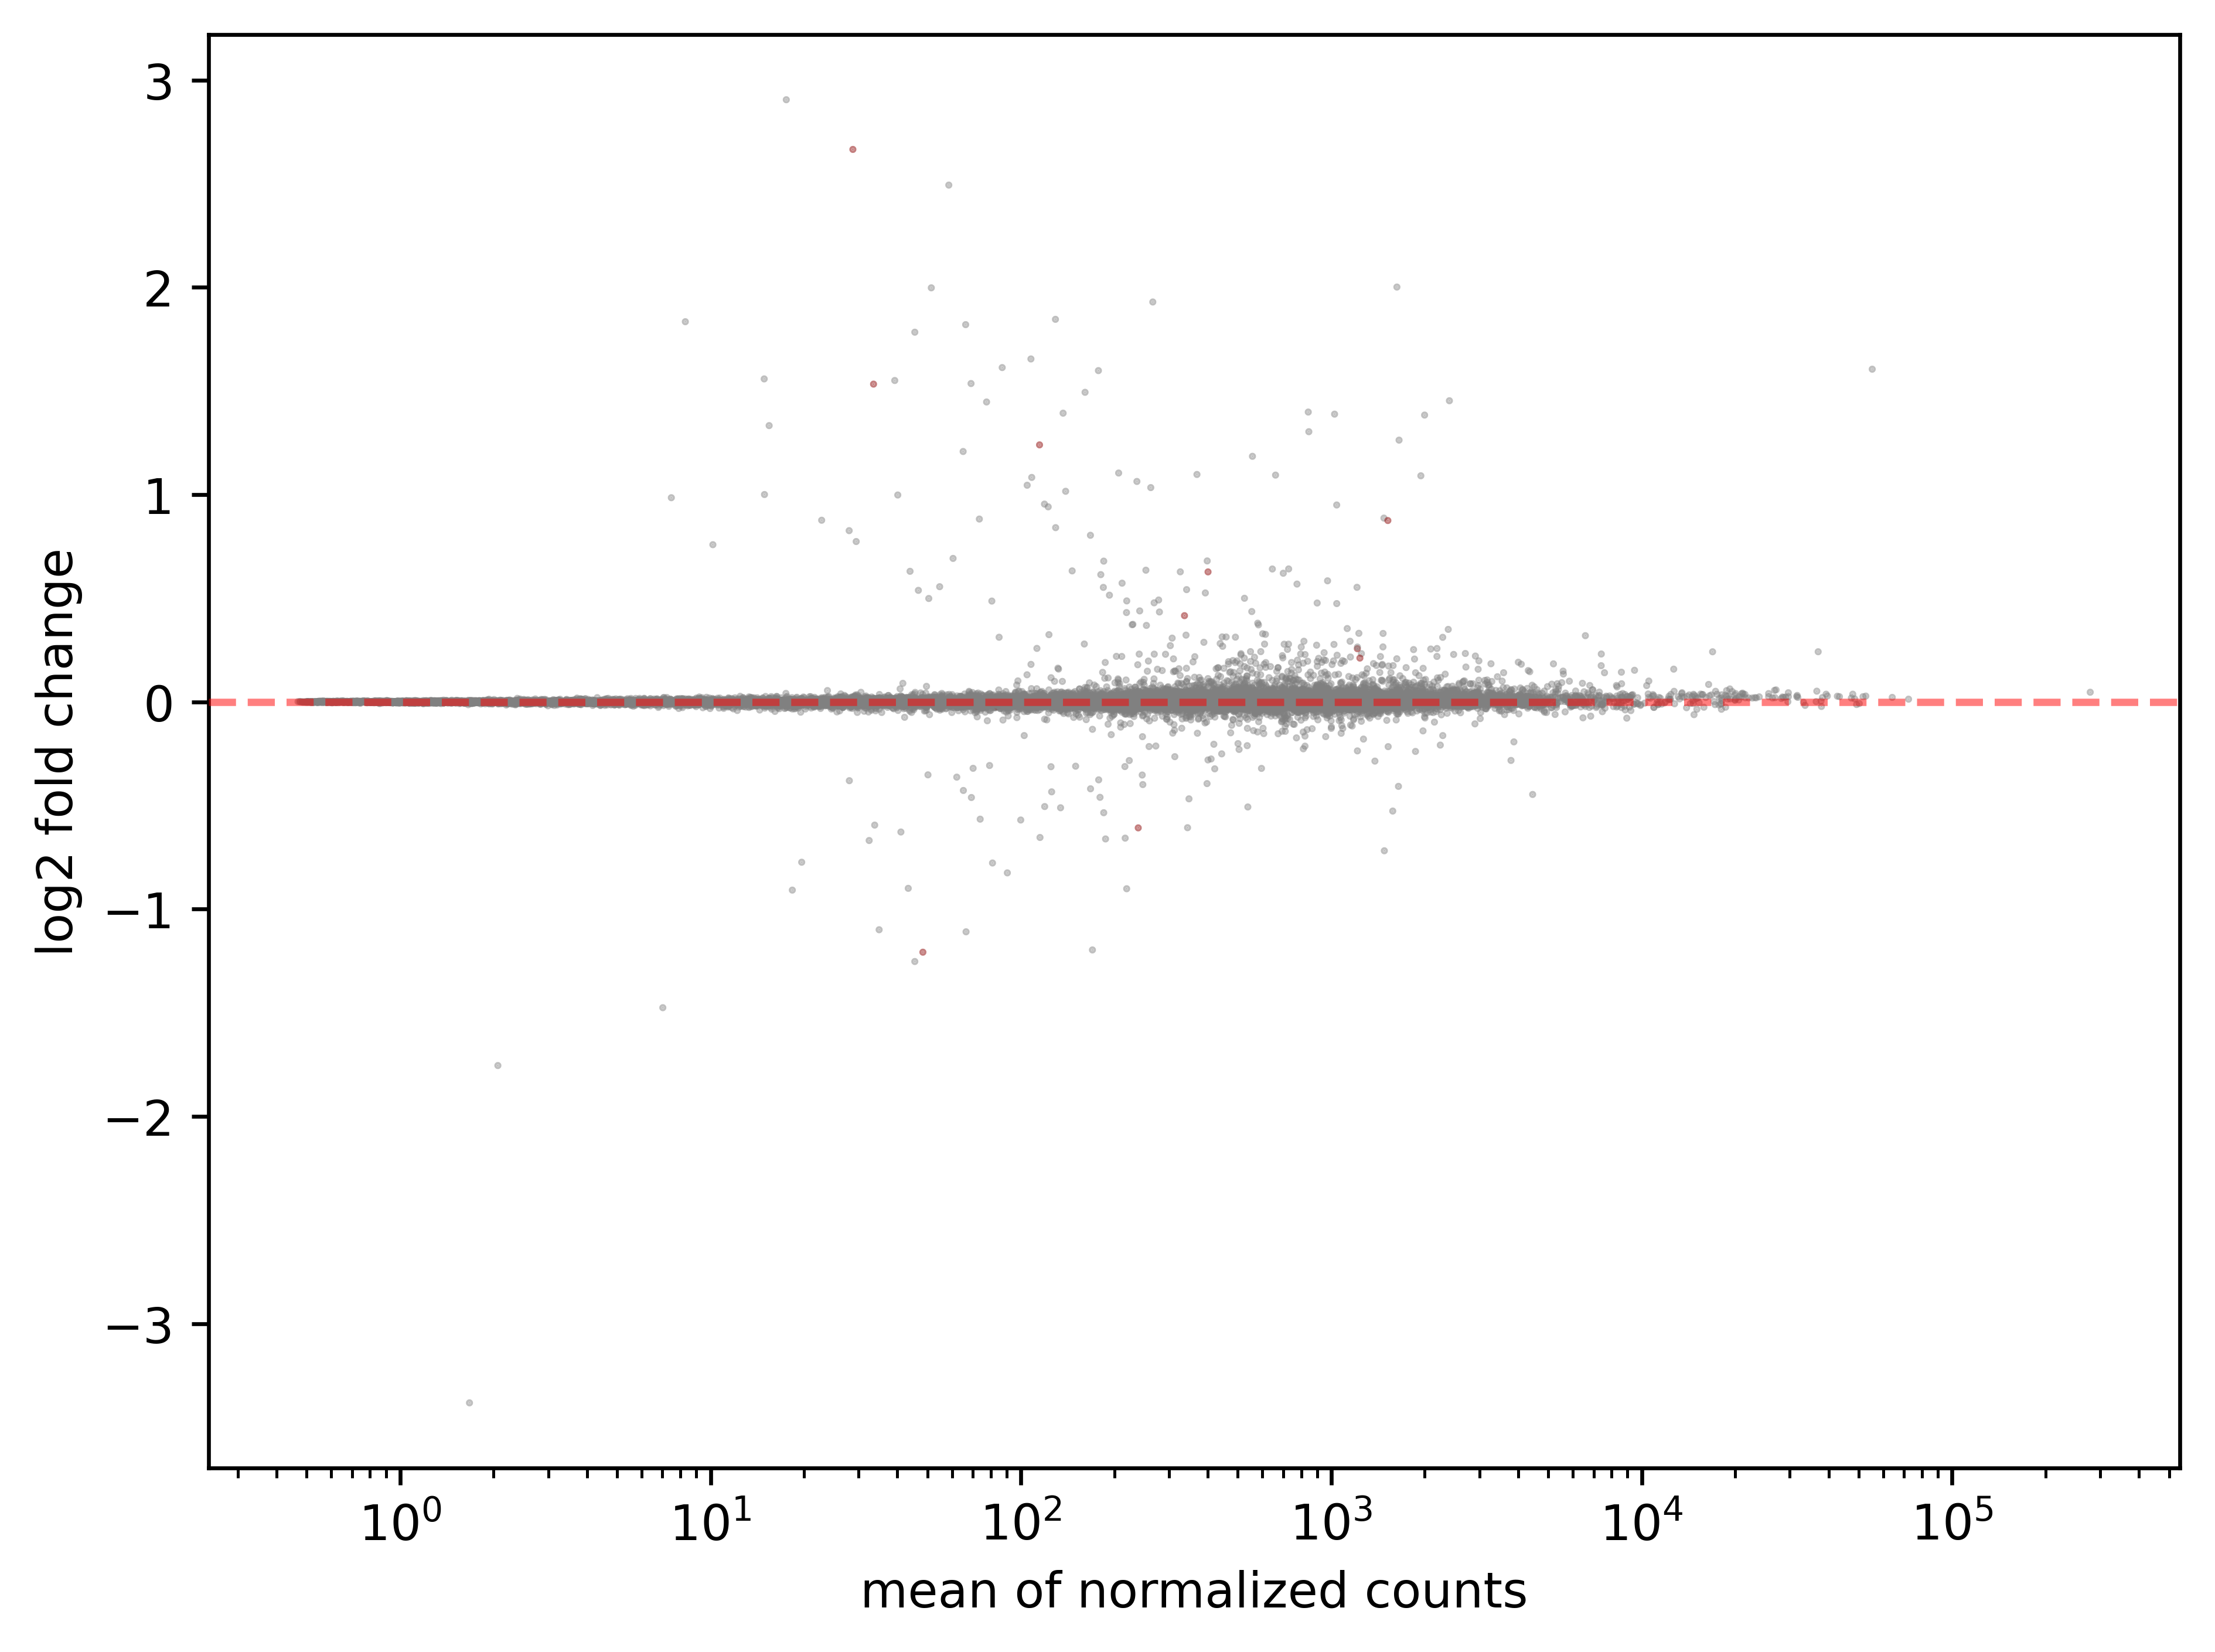

In [ ]:
ds.plot_MA(save_path="/content/drive/My Drive/BENG204_Project/BENG204_Project_Figures/")


We now generate a volcano plot for the Ho et al DEGs.

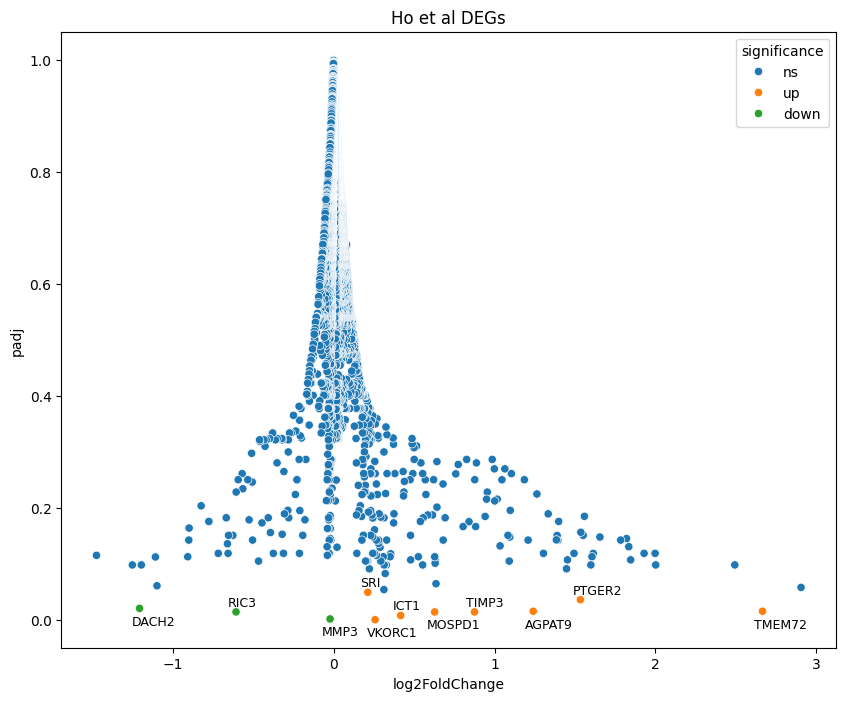

In [45]:
plt.figure(figsize=(10, 8))
volcano = sns.scatterplot(ds_df, x = 'log2FoldChange', y = 'padj', hue='significance')
volcano.set_title("Ho et al DEGs")
DEGs = ["DACH2", "RIC3", "MMP3", "SRI", "VKORC1", "ICT1", "MOSPD1", "TIMP3", "AGPAT9", "PTGER2", "TMEM72"]
for i, row in DEGs_df.iterrows():
    if row['gene_symbol'] in DEGs:
      if i % 2 == 1:
        volcano.text(row['log2FoldChange']-0.05, row['padj']+0.01, row['gene_symbol'], fontsize=9)
      else:
        volcano.text(row['log2FoldChange']-0.05, row['padj']-0.03, row['gene_symbol'], fontsize=9)

Save the volcano plot:

In [47]:
volcano.figure.savefig("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_volcano.png", dpi=300)